# Cycle GAN

In [ ]:
!pip install torch torchviz matplotlib torchview albumentations

In [4]:
import torch 
import torch.nn as nn
import os
import torch
import torch.nn as nn
import albumentations as A
import torch.optim as optim

import torch.nn.functional as F
from torchvision.utils import save_image
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader


from torchview import draw_graph
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
import numpy as np

## Generator Model

torch.Size([1, 3, 256, 256])


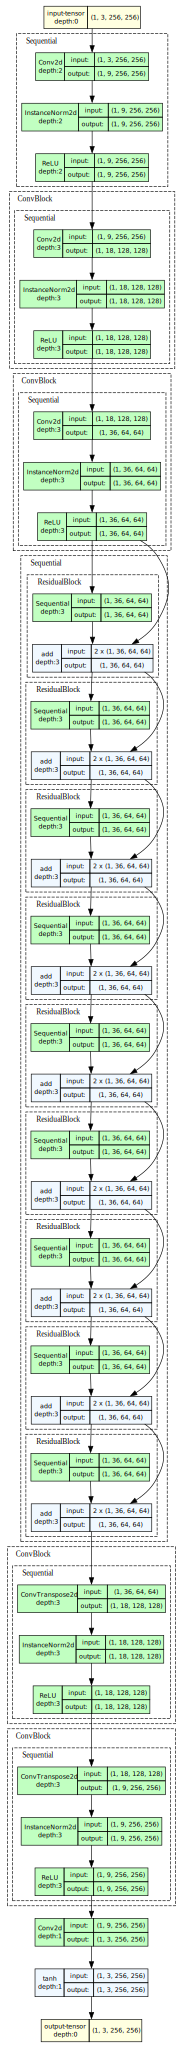

In [74]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, down=True, use_act=True, **kwargs):
        super().__init__()
        # Downsampling uses Conv2d, upsampling uses ConvTranspose2d
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, padding_mode="reflect", **kwargs) 
            if down else nn.ConvTranspose2d(in_channels, out_channels,  **kwargs),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU() if use_act else nn.Identity()
        )

    def forward(self, x):
        return self.conv(x)


class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.block = nn.Sequential(
            ConvBlock(channels, channels, kernel_size=3, padding=1),
            ConvBlock(channels, channels, use_act=False, kernel_size=3, padding=1),
        )
    
    def forward(self, x):
        return x + self.block(x)

class Generator(nn.Module):
    
    def __init__(self, img_channels, num_features=64, num_residuals=9):
        
        super().__init__()
        
        self.initial = nn.Sequential(
            nn.Conv2d(img_channels, num_features, kernel_size=7, stride=1, padding=3, padding_mode="reflect"),
            nn.InstanceNorm2d(num_features),
            nn.ReLU(inplace=True),
        )
        
        self.down_blocks = nn.ModuleList([
            ConvBlock(num_features, num_features*2, kernel_size=3, stride=2, padding=1),
            ConvBlock(num_features * 2, num_features*4, kernel_size=3, stride=2, padding=1),
        ])
        
        self.res_blocks = nn.Sequential(
            *[ResidualBlock(num_features*4) for _ in range(num_residuals)]
        )
        
        self.up_blocks = nn.ModuleList([
            ConvBlock(num_features * 4, num_features * 2, down=False, kernel_size=3, stride=2, padding=1, output_padding=1),
            ConvBlock(num_features * 2, num_features, down=False, kernel_size=3, stride=2, padding=1, output_padding=1),
        ])
        
        self.last = nn.Conv2d(num_features * 1, img_channels, kernel_size=7, stride=1, padding=3, padding_mode="reflect")
    
    def forward(self, x):
        x = self.initial(x)
        
        for layer in self.down_blocks:
            x = layer(x)
            
        x = self.res_blocks(x)
        
        for layer in self.up_blocks:
            x = layer(x)
            
        x = self.last(x)
        
        return torch.tanh(x)
        
img_channels = 3
img_size = 256
x = torch.randn((1, img_channels, img_size, img_size))
gen = Generator(img_channels, num_features=9)
print(gen(x).shape)
architecture = 'Generator'
model_graph = draw_graph(gen, input_data=(x),  
                             graph_dir='TB', roll=True,
                             expand_nested=True, graph_name=f'self_{architecture}', 
                             save_graph=True, filename=f'self_{architecture}')
model_graph.visual_graph

## Discriminator Model

torch.Size([1, 1, 30, 30])


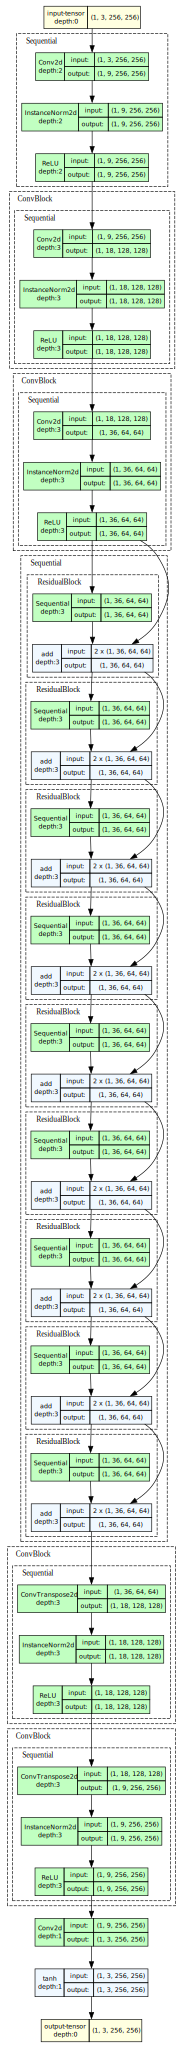

In [75]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super().__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=stride, padding=1, bias=True, padding_mode="reflect"),
            nn.InstanceNorm2d(out_channels),
            nn.LeakyReLU(0.2, inplace=True),
        )
        
    def forward(self, x):
        return self.conv(x)
    
class Discriminator(nn.Module):
    def __init__(self, in_channels=2, features=[64, 128, 256, 512]):
        super().__init__()
        
        self.initial = nn.Sequential(
            nn.Conv2d(in_channels, features[0], kernel_size=4, stride=2, padding=1, padding_mode="reflect"),
            nn.LeakyReLU(0.2, inplace=True),
        )
        
        layers = []
        in_channels = features[0]
        for feature in features[1:]:
            layers.append(
                Block(in_channels, feature, stride=1 if feature == features[-1] else 2),
            )
            in_channels = feature
            
        layers.append(
            nn.Conv2d(in_channels, 1 , kernel_size=4, stride=1, padding=1, padding_mode="reflect")
        )
            
        self.model = nn.Sequential(
            *layers
        )
        
    def forward(self, x):
        x = self.initial(x)
        return torch.sigmoid(self.model(x))
    
x = torch.randn((1, 3, 256, 256))
model = Discriminator(in_channels=3)
preds = model(x)
print(preds.shape)
architecture = 'Generator'
model_graph = draw_graph(gen, input_data=(x),  
                             graph_dir='TB', roll=True,
                             expand_nested=True, graph_name=f'self_{architecture}', 
                             save_graph=True, filename=f'self_{architecture}')
model_graph.visual_graph

## HYPERPARAMETERS

In [76]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 1
LEARNING_RATE = 1e-5
LAMBDA_IDENTITY = 0.0
LAMBDA_CYCLE = 10
NUM_WORKERS = 4
NUM_EPOCHS = 10
LOAD_MODEL = False
SAVE_MODEL = True
CHECKPOINT_GEN_H = "genh.pth.tar"
CHECKPOINT_GEN_Z = "genz.pth.tar"
CHECKPOINT_CRITIC_H = "critich.pth.tar"
CHECKPOINT_CRITIC_Z = "criticz.pth.tar"

transforms = A.Compose(
    [
        A.Resize(width=256, height=256),
        A.HorizontalFlip(p=0.5),
        A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255),
        ToTensorV2(),
    ],
    additional_targets={"image0": "image"},
)
DEVICE

'cuda'

## UTILS

In [77]:
def save_checkpoint(model, optimizer, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, filename)


def load_checkpoint(checkpoint_file, model, optimizer, lr):
    print("=> Loading checkpoint")
    checkpoint = torch.load(checkpoint_file, map_location=config.DEVICE)
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])


    for param_group in optimizer.param_groups:
        param_group["lr"] = lr


def seed_everything(seed=42):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

## DATASET CLASS

In [78]:
class HorseZebraDataset(Dataset):
    def __init__(self, root_zebra, root_horse, transform=None):
        self.root_zebra = root_zebra
        self.root_horse = root_horse
        self.transform = transform

        self.zebra_images = os.listdir(root_zebra)
        self.horse_images = os.listdir(root_horse)
        self.length_dataset = max(len(self.zebra_images), len(self.horse_images)) # 1000, 1500
        self.zebra_len = len(self.zebra_images)
        self.horse_len = len(self.horse_images)

    def __len__(self):
        return self.length_dataset

    def __getitem__(self, index):
        zebra_img = self.zebra_images[index % self.zebra_len]
        horse_img = self.horse_images[index % self.horse_len]

        zebra_path = os.path.join(self.root_zebra, zebra_img)
        horse_path = os.path.join(self.root_horse, horse_img)

        zebra_img = np.array(Image.open(zebra_path).convert("RGB"))
        horse_img = np.array(Image.open(horse_path).convert("RGB"))

        if self.transform:
            augmentations = self.transform(image=zebra_img, image0=horse_img)
            zebra_img = augmentations["image"]
            horse_img = augmentations["image0"]

        return zebra_img, horse_img

## TRAIN FUNCTION

In [87]:
def train_fn(
    disc_H, disc_Z, gen_Z, gen_H, loader, opt_disc, opt_gen, l1, mse, d_scaler, g_scaler
):
    H_reals = 0
    H_fakes = 0
    
    loop = tqdm(loader, leave=True)
    
    for idx, (zebra, horse) in enumerate(loop):
        zebra = zebra.to(DEVICE)
        horse = horse.to(DEVICE)
        
        # Discriminator forward and loss computation
        with torch.cuda.amp.autocast():
            fake_horse = gen_H(zebra)
            D_H_real = disc_H(horse)
            D_H_fake = disc_H(fake_horse.detach())
            H_reals += D_H_real.mean().item()
            H_fakes  += D_H_fake.mean().item()
            D_H_real_loss = mse(D_H_real, torch.ones_like(D_H_real))
            D_H_fake_loss = mse(D_H_fake, torch.zeros_like(D_H_fake))
            D_H_loss = D_H_real_loss + D_H_fake_loss
            
            fake_zebra = gen_Z(horse)
            D_Z_real = disc_Z(zebra)
            D_Z_fake = disc_Z(fake_zebra.detach())  # Detach here
            D_Z_real_loss = mse(D_Z_real, torch.ones_like(D_Z_real))
            D_Z_fake_loss = mse(D_Z_fake, torch.zeros_like(D_Z_fake))
            D_Z_loss = D_Z_real_loss + D_Z_fake_loss
            
            # Total discriminator loss
            D_loss = (D_H_loss + D_Z_loss) / 2

        # Backprop for discriminator
        opt_disc.zero_grad()
        d_scaler.scale(D_loss).backward()
        d_scaler.step(opt_disc)
        d_scaler.update()
        
        # Generator forward and loss computation
        with torch.cuda.amp.autocast():
            D_H_fake = disc_H(fake_horse)
            D_Z_fake = disc_Z(fake_zebra)
            loss_G_H = mse(D_H_fake, torch.ones_like(D_H_fake))
            loss_G_Z = mse(D_Z_fake, torch.ones_like(D_Z_fake))

            # Cycle consistency loss
            cycle_zebra = gen_Z(fake_horse)
            cycle_horse = gen_H(fake_zebra)
            cycle_zebra_loss = l1(zebra, cycle_zebra)
            cycle_horse_loss = l1(horse, cycle_horse)

            # Identity loss
            identity_zebra = gen_Z(zebra)
            identity_horse = gen_H(horse)
            identity_zebra_loss = l1(zebra, identity_zebra)
            identity_horse_loss = l1(horse, identity_horse)

            # Total generator loss
            G_loss = (
                loss_G_H + loss_G_Z +
                cycle_zebra_loss * LAMBDA_CYCLE +
                cycle_horse_loss * LAMBDA_CYCLE +
                identity_zebra_loss * LAMBDA_IDENTITY +
                identity_horse_loss * LAMBDA_IDENTITY
            )
        
        # Backprop for generator
        opt_gen.zero_grad()
        g_scaler.scale(G_loss).backward()  # Single backward call for G_loss
        g_scaler.step(opt_gen)
        g_scaler.update()

        # Save images periodically
        if idx % 200 == 0:
            save_image(fake_horse * 0.5 + 0.5, f"saved_images/horse_{idx}.png")
            save_image(fake_zebra * 0.5 + 0.5, f"saved_images/zebra_{idx}.png")

        # Update loop info
        loop.set_postfix(H_real=H_reals / (idx + 1), H_fake=H_fakes / (idx + 1))


In [88]:
def main():
    disc_H = Discriminator(in_channels=3).to(DEVICE)
    disc_Z = Discriminator(in_channels=3).to(DEVICE)
    gen_Z = Generator(img_channels=3, num_residuals=9).to(DEVICE)
    gen_H = Generator(img_channels=3, num_residuals=9).to(DEVICE)
    opt_disc = optim.Adam(
        list(disc_H.parameters()) + list(disc_Z.parameters()),
        lr=LEARNING_RATE,
        betas=(0.5, 0.999),
    )

    opt_gen = optim.Adam(
        list(gen_Z.parameters()) + list(gen_H.parameters()),
        lr=LEARNING_RATE,
        betas=(0.5, 0.999),
    )

    L1 = nn.L1Loss()
    mse = nn.MSELoss()

    if LOAD_MODEL:
        load_checkpoint(
            CHECKPOINT_GEN_H,
            gen_H,
            opt_gen,
            LEARNING_RATE,
        )
        load_checkpoint(
            CHECKPOINT_GEN_Z,
            gen_Z,
            opt_gen,
            LEARNING_RATE,
        )
        load_checkpoint(
            CHECKPOINT_CRITIC_H,
            disc_H,
            opt_disc,
            LEARNING_RATE,
        )
        load_checkpoint(
            CHECKPOINT_CRITIC_Z,
            disc_Z,
            opt_disc,
            LEARNING_RATE,
        )

    dataset = HorseZebraDataset(
        root_horse="/kaggle/input/horse2zebra-dataset/trainA",
        root_zebra="/kaggle/input/horse2zebra-dataset/trainB",
        transform=transforms,
    )
    val_dataset = HorseZebraDataset(
        root_horse="/kaggle/input/horse2zebra-dataset/testA",
        root_zebra="/kaggle/input/horse2zebra-dataset/testB",
        transform=transforms,
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=1,
        shuffle=False,
        pin_memory=True,
    )
    loader = DataLoader(
        dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=NUM_WORKERS,
        pin_memory=True,
    )
    g_scaler = torch.cuda.amp.GradScaler()
    d_scaler = torch.cuda.amp.GradScaler()

    for epoch in range(NUM_EPOCHS):
        train_fn(
            disc_H,
            disc_Z,
            gen_Z,
            gen_H,
            loader,
            opt_disc,
            opt_gen,
            L1,
            mse,
            d_scaler,
            g_scaler,
        )

        if SAVE_MODEL:
            save_checkpoint(gen_H, opt_gen, filename=CHECKPOINT_GEN_H)
            save_checkpoint(gen_Z, opt_gen, filename=CHECKPOINT_GEN_Z)
            save_checkpoint(disc_H, opt_disc, filename=CHECKPOINT_CRITIC_H)
            save_checkpoint(disc_Z, opt_disc, filename=CHECKPOINT_CRITIC_Z)

In [ ]:
main()

/tmp/ipykernel_36/3845790220.py:70: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  g_scaler = torch.cuda.amp.GradScaler()
/tmp/ipykernel_36/3845790220.py:71: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  d_scaler = torch.cuda.amp.GradScaler()
  0%|          | 0/1334 [00:00<?, ?it/s]/tmp/ipykernel_36/2188617238.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/tmp/ipykernel_36/2188617238.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
 32%|███▏      | 428/1334 [01:39<03:28,  4.34it/s, H_fake=0.463, H_real=0.528]